# Conditional VAE

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import MNIST
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch import Tensor
from tqdm import tqdm

# Set the main device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data

In [17]:
# CAR DATA
# Load car data for project 2
import torchvision
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
import litdata


class ToRGBTensor:
    """Code from Mariuaas copied from Discourse"""
    def __call__(self, img):
        return transforms.functional.to_tensor(img).expand(3, -1, -1)  # Expand to 3 channels

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"
    
    
class GetMoiraLabel:
    def __call__(self, tensor):
        return int(tensor.squeeze()[1])

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


def get_data(input_shape: list):
    """
    Get train and test data loader based on educload .tar data
    Code adapted from Mariuaas from Discourse
    """
    # Define data path
    DATA_PATH = '/projects/ec232/data/'

    # Define mean and std from ImageNet data
    IN_MEAN = [0.485, 0.456, 0.406]
    IN_STD = [0.229, 0.224, 0.225]

    # Define postprocessing / transform of data modalities
    postprocess = (  # Create tuple for image and class...
        transforms.Compose([  # Handles processing of the .jpg image
            ToRGBTensor(),  # Convert from PIL image to RGB torch.Tensor
            transforms.Grayscale(num_output_channels=input_shape[2]),
            transforms.Resize(input_shape[:2]),  # Resize images
            #transforms.Normalize(IN_MEAN, IN_STD),  # Normalize image to correct mean/std
            #transforms.Normalize(0.5, 0.5),
            
        ]),
        transforms.Compose([  # Handles processing of the .jpg image
            transforms.ToTensor(), # Convert .scores.npy file to tensor
            GetMoiraLabel(),
        ])
    )

    # Load data
    data = litdata.LITDataset(
        "CarRecs",
        DATA_PATH,
        override_extensions=["jpg", "scores.npy"],  # first load image, then scores
    ).map_tuple(*postprocess)

    return data

N_CHANNELS = 1
#INPUT_SHAPE = [96, 96, N_CHANNELS]
INPUT_SHAPE = [28, 28, N_CHANNELS]
# INPUT_SHAPE = [96, 128, N_CHANNELS]
batch_size = 64 * 4

ORIGINAL = False
train_set = get_data(INPUT_SHAPE)

# Create data loader
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
train_set[0][0].size()

torch.Size([1, 28, 28])

In [18]:
ORIGINAL = True

In [390]:
train_set[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [391]:
# MNIST DATA
# Choose the path where you will/have already saved the MNIST dataset
data_dir = '/fp/projects01/ec232/data'

# Get dataset
ORIGINAL = True
batch_size = 64 * 4
INPUT_SHAPE = [28, 28, 1]
N_CHANNELS = 1
transform = transforms.ToTensor()
train_set = MNIST(root=data_dir, train=True, download=True, transform=transform)
N = len(train_set)

# Create data loader
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
train_set[0][0].size()

torch.Size([1, 28, 28])

## Helper functions

In [4]:
def reparameterize_gaussian(mean, std):
    """
    Inputs:
        mean : [torch.tensor] Mean vector. Shape: batch_size x z_dim.
        std  : [torch.tensor] Standard deviation vection. Shape: batch_size x z_dim.
    
    Output:
        z    : [torch.tensor] z sampled from the Normal distribution with mean and standard deviation given by the inputs. 
                              Shape: batch_size x z_dim.
    """

    # Sample epsilon from N(0,I)
    eps = torch.randn_like(std)

    # Calculate z using reparameterization trick
    z = mean + std*eps

    return z

In [5]:
def get_vae_loss(x, x_hat, mean, logvar):
    """
    Inputs:
        x       : [torch.tensor] Original sample
        x_hat   : [torch.tensor] Reproduced sample
        mean    : [torch.tensor] Mean mu of the variational posterior given sample x
        logvar  : [torch.tensor] log of the variance sigma^2 of the variational posterior given sample x
    """

    # Recontruction loss
    reconstruction_loss = ((x - x_hat)**2).sum()
    #print("RL", reconstruction_loss)
    
    # KL divergence
    KL_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    #print("KL", KL_divergence)
    
    # Get the total loss
    kl_weight = 1
    loss = reconstruction_loss + KL_divergence * kl_weight

    return loss / 10

In [8]:
class ResidualLayer(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int):
        super(ResidualLayer, self).__init__()
        self.resblock = nn.Sequential(nn.Conv2d(in_channels, out_channels,
                                                kernel_size=3, padding=1, bias=False),
                                      nn.ReLU(True),
                                      nn.Conv2d(out_channels, out_channels,
                                                kernel_size=1, bias=False))

    def forward(self, input: Tensor) -> Tensor:
        return input + self.resblock(input)

# cVAE

In [23]:
class CEncoder(nn.Module):
    """ Convolutional encoder for the CVAE. """

    def __init__(self, z_dim, n_classes, n_channels):
        super().__init__()

        feature_dim = 32 * 23 * 31
        if ORIGINAL: feature_dim = 32 * 6 * 6  # TODO HOW DO I ARRIVE AT THESE NUMBERS?
        self.conv1 = nn.Conv2d(n_channels + 1, 64, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=2)
        self.mean_fc = nn.Linear(feature_dim, z_dim)
        self.logvar_fc = nn.Linear(feature_dim, z_dim)
        self.cls_token_fc = nn.Linear(feature_dim, n_classes)

    def forward(self, x):
        #x = torch.flatten(x)
        #print("forward encoder:", x.size())
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #print(x.size())  # [64, 32, 23, 31]  # [64, 32, 6, 6]
        x = x.flatten(1)
        
        # TODO also try out other priors
        mean = self.mean_fc(x)
        logvar = self.logvar_fc(x)
        cls_token = self.cls_token_fc(x)

        return mean, logvar, cls_token

In [24]:
class CDecoder(nn.Module):
    """ Convolutional decoder for the CVAE. """

    def __init__(self, z_dim, n_classes, n_channels):
        super().__init__()
        
        feature_dim = 32 * 23 * 31
        if ORIGINAL: feature_dim = 32 * 6 * 6
        self.fc = nn.Linear(z_dim + n_classes, feature_dim)
        self.conv2 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2)
        self.conv1 = nn.ConvTranspose2d(64, n_channels, kernel_size=3, stride=2, output_padding=1)

    def forward(self, z):
        # print("dec z.size()", z.size())
        x = F.relu(self.fc(z))
        if ORIGINAL: x = x.view(-1, 32, 6, 6) 
        else: x = x.view(-1, 32, 23, 31)
        x = F.relu(self.conv2(x))
        x = self.conv1(x)
        x = torch.sigmoid(x)
        
        return x

## Extended cVAE

In [43]:
class CEncoder(nn.Module):
    """ Convolutional encoder for the CVAE. """

    def __init__(self, z_dim, n_classes, n_channels, hidden_dims=None):
        super().__init__()

        in_channels = n_channels + 1
                
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]
            #hidden_dims = [32, 128, 512]

        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
        
        self.encoder = nn.Sequential(*modules)
        
        feature_dim = 512 * 3 * 3
        if ORIGINAL: feature_dim = 512 * 1 * 1
        self.mean_fc = nn.Linear(feature_dim, z_dim)
        self.logvar_fc = nn.Linear(feature_dim, z_dim)
        self.cls_token_fc = nn.Linear(feature_dim, n_classes)

    def forward(self, x):
        x = self.encoder(x)
        #print("!!! feature_dim:", x.size())  # [64, 32, 23, 31]  # [64, 32, 6, 6]
        x = x.flatten(1)
        
        # TODO also try out other priors
        mean = self.mean_fc(x)
        logvar = self.logvar_fc(x)
        cls_token = self.cls_token_fc(x)

        return mean, logvar, cls_token

In [44]:
class CDecoder(nn.Module):
    """ Convolutional decoder for the CVAE. """

    def __init__(self, z_dim, n_classes, n_channels, hidden_dims=None):
        super().__init__()
        
        feature_dim = 512 * 3 * 3
        if ORIGINAL: feature_dim = 512 * 1 * 1
        self.fc = nn.Linear(z_dim + n_classes, feature_dim)
        
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]
            #hidden_dims = [32, 128, 512]
        hidden_dims.reverse()
        
        padding_last_layer = 1
        if ORIGINAL: padding_last_layer = 3
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*modules)       
        
        self.final_layer = nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[-1],
                                       hidden_dims[-1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[-1]),
                    nn.LeakyReLU(),
                    nn.ConvTranspose2d(hidden_dims[-1], 
                              out_channels=n_channels,
                              kernel_size=3, 
                              padding=padding_last_layer),
                    nn.Tanh())

    def forward(self, z):
        x = self.fc(z)
        if ORIGINAL:  x = x.view(-1, 512, 1, 1)
        else: x = x.view(-1, 512, 3, 3)
        x = self.decoder(x)
        # print("after decoder:", x.size())
        x = self.final_layer(x)
        # print("after final_layer:", x.size())
        
        return x

## Declare cVAE

In [45]:
class CVAE(nn.Module):
    """ Conditional Variational Auto-Encoder class. """

    def __init__(self, z_dim, n_classes, n_channels=1, img_size=[28,28]):
        super().__init__()
        self.z_dim = z_dim
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.img_size = img_size

        self.encoder = CEncoder(z_dim, n_classes, n_channels)
        self.decoder = CDecoder(z_dim, n_classes, n_channels)

        # Add learnable class token
        self.cls_param = nn.Parameter(torch.zeros(n_classes, *img_size))

    def get_cls_emb(self, c):
        return self.cls_param[c].unsqueeze(1)

    def forward(self, x, c):
        """
        Args:
            x   : [torch.Tensor] Image input of shape [batch_size, n_channels, *img_size]
            c   : [torch.Tensor] Class labels for x of shape [batch_size], where the class in indicated by a
        """

        # Get cls embedding
        cls_emb = self.get_cls_emb(c)

        # Concatenate cls embedding to the input
        #print("x.size() =", x.size())
        #print("cls_emb.size() =", cls_emb.size())
        x = torch.cat((x, cls_emb), dim=1)

        # Get the mean, logvar, and cls token from the encoder
        mean, logvar, cls_token = self.encoder(x)

        # Calculate the standard deviation. Note: in log-space, squareroot is divide by two
        std = torch.exp(logvar / 2)

        # Sample the latent using the reparameterization trick
        z = reparameterize_gaussian(mean, std)
        # print("######")
        # print("z.size() =", z.size())
        
        # Concatenate cls token to z
        z = torch.cat((z, F.softmax(cls_token, dim=1)), dim=1)
        
        # Get reconstructed x from the decoder
        x_hat = self.decoder(z)
        
        return x, x_hat, mean, logvar, cls_token

## Train model

In [55]:
# Initialize the VAE
z_dim = 128
conditioned_model = CVAE(z_dim, n_classes=10, n_channels=N_CHANNELS, img_size=INPUT_SHAPE[:2]).to(device)

# Feel free to tweak the training parameters
epochs = 25
lr = 0.00001
optimizer = Adam(conditioned_model.parameters(), lr=lr)

# Train for a few epochs
conditioned_model.train()

losses = []

# TODO USE: with traindata.shufflecontext(): 2 # do training loop ...
for epoch in range(epochs):
    train_bar = tqdm(iterable=train_loader)
    total_loss = 0
    for i, (x, c) in enumerate(train_bar):
        x = x.to(device)
        c = c.to(device)
        # Get x_hat, mean, logvar,and cls_token from the conditioned_model
        x, x_hat, mean, logvar, cls_token = conditioned_model.forward(x, c)
        x = x[:, :N_CHANNELS, :, :] # excluding cls_emebdding

        # Get vae loss
        #print("x.size() =", x.size())
        #print("x_hat.size() =", x_hat.size())        
        vae_loss = get_vae_loss(x, x_hat, mean, logvar)

        # Get cross entropy loss for the cls token
        # print("cls_token.size() =", cls_token.size())
        # print("OHE", F.one_hot(c, num_classes=10).double().size())
        cls_loss = F.cross_entropy(cls_token, F.one_hot(c, num_classes=10).double(), reduction='sum')

        # Add the losses as a weighted sum. NB: We weight the cls_loss by 10 here, but feel free to tweak it.
        loss = vae_loss + cls_loss  #* 10 # reducing vae_loss instead
        total_loss += loss / len(x)
        
        # Update model parameters based on loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_bar.set_description(f'Epoch [{epoch+1}/{epochs}]')
        train_bar.set_postfix(loss = loss.item() / len(x))
    losses.append(total_loss.item())
    print("Total loss:", losses[-1])

Epoch [1/25]: 100%|██████████| 24/24 [00:23<00:00,  1.00it/s, loss=30.1]


Total loss: 722.8829916780815


Epoch [2/25]: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s, loss=28.3]


Total loss: 680.079500053211


Epoch [3/25]: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s, loss=25.1]


Total loss: 632.5784946904917


Epoch [4/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=21.8]


Total loss: 567.6566204883026


Epoch [5/25]: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it, loss=18.5]


Total loss: 484.789930820332


Epoch [6/25]: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it, loss=14.8]


Total loss: 396.40340279807737


Epoch [7/25]: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s, loss=12.2]


Total loss: 319.7018732940778


Epoch [8/25]: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s, loss=11.1]


Total loss: 276.0450616915311


Epoch [9/25]: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s, loss=10.3]


Total loss: 255.26597501999433


Epoch [10/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=10.1]


Total loss: 242.1750602811974


Epoch [11/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=9.79]


Total loss: 232.53389100657245


Epoch [12/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=9.08]


Total loss: 224.23956043875245


Epoch [13/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=8.77]


Total loss: 217.74838012716333


Epoch [14/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=9.06]


Total loss: 212.7707343991247


Epoch [15/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=8.5] 


Total loss: 207.46637141554882


Epoch [16/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=8.46]


Total loss: 203.74152185890958


Epoch [17/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=8.27]


Total loss: 199.8839218844327


Epoch [18/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=8.66]


Total loss: 196.97103194486616


Epoch [19/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=8.16]


Total loss: 194.04251712277932


Epoch [20/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=8.13]


Total loss: 191.06769202716117


Epoch [21/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=7.95]


Total loss: 188.7993001922566


Epoch [22/25]: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it, loss=7.37]


Total loss: 186.72732474352233


Epoch [23/25]: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it, loss=7.48]


Total loss: 184.94273370215004


Epoch [24/25]: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it, loss=7.59]


Total loss: 183.104915134642


Epoch [25/25]: 100%|██████████| 24/24 [00:24<00:00,  1.02s/it, loss=7.72]

Total loss: 181.44516321890322


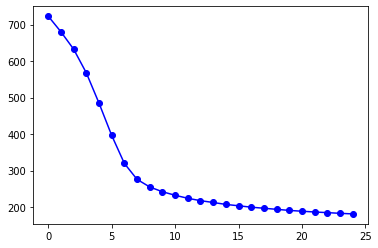

In [57]:
# Print convergence plot
plt.plot(losses, "-bo")

In [ ]:
# This doesn't work
# x.size() = torch.Size([64, 4, 96, 128])
# x_hat.size() = torch.Size([64, 3, 96, 128])
#x - x_hat

To generate new images conditioned on a class label, we sample some noise $z \sim N(0,I)$ and concatenate the one-hot vector of the class label we want to condition on. Then we use the decoder to generate a new image.
If your CVAE model was trained correctly, the cell below should generate new images of the selected class.

## Get generations

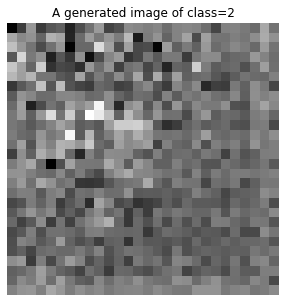

In [64]:
# Put model in evalulation mode
conditioned_model.eval()

# Select a class label
cls_label = 2

with torch.no_grad():
    # Sample noise from N(0,I)
    # TODO also try out other priors
    z = torch.randn(1, z_dim).to(device)

    # Make a one-hot for the selected class label, which will act as the cls token
    cls_token = F.one_hot(torch.tensor(cls_label).unsqueeze(0), num_classes=10).to(device)

    # Concatenate z and the cls token
    z = torch.cat((z, cls_token), dim=1)  # TODO prob this should be saved acc to instructions!

    # Generate new image with the decoder
    x_hat = conditioned_model.decoder(z)
    x_hat = x_hat.squeeze(0).cpu().detach()

# Show generated image
plt.figure(figsize=(5,5))
x_hat_permuted = x_hat.permute(1, 2 ,0)
#plt.imshow((x_hat_permuted+1)*.5, cmap=plt.get_cmap('gray'))
plt.imshow(x_hat_permuted, cmap=plt.get_cmap('gray'))
plt.title(f"A generated image of class={cls_label}")
plt.axis('off')
plt.show()

Preference score: 2


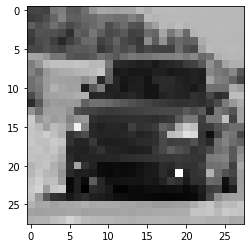

In [334]:
print("Preference score:", train_set[i][1])
plt.imshow(train_set[i][0].permute(1,2,0), cmap=plt.get_cmap('gray'))
plt.show()
i += 1

### Dataset Analysis

In [304]:
raise Exception("stop")

Exception: stop

In [305]:
scores = []
for i in range(len(train_set)):
    scores.append(train_set[i][1])

In [308]:
from collections import Counter
Counter(scores)

Counter({2: 1226,
         1: 1724,
         0: 1163,
         5: 335,
         3: 764,
         7: 82,
         4: 496,
         6: 179,
         8: 27,
         9: 4})

In [309]:
# Score = 9: [562, 2984, 3392, 4864]

In [310]:
i = 4

Preference score: 5


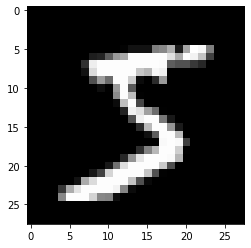

In [141]:
print("Preference score:", train_set[i][1])
permuted_train_set = train_set[i][0].permute(1,2,0)

plt.imshow((permuted_train_set+1)*.5, cmap=plt.get_cmap('gray'))
plt.show()
#i += 1

In [104]:
(train_set[0][0]+1)*256/2

tensor([[[ 83.4710,  84.0139,  80.3743,  ..., 103.8327,  92.7517,  66.2770],
         [107.6457,  92.3275,  70.3172,  ..., 114.7835, 107.3760, 102.4781],
         [ 94.4461,  99.4346,  83.4237,  ..., 119.2529, 109.8161, 103.0797],
         ...,
         [ 96.7647,  98.9268, 104.6256,  ...,  75.2343,  75.2343,  75.2343],
         [ 93.7166,  98.3483, 102.9799,  ...,  73.2267,  73.2267,  73.2267],
         [ 86.0207,  93.3292,  98.1281,  ...,  73.0593,  72.2228,  73.0593]],

        [[ 83.4710,  84.0139,  80.3743,  ..., 103.8327,  92.7517,  66.2770],
         [107.6457,  92.3275,  70.3172,  ..., 114.7835, 107.3760, 102.4781],
         [ 94.4461,  99.4346,  83.4237,  ..., 119.2529, 109.8161, 103.0797],
         ...,
         [ 96.7647,  98.9268, 104.6256,  ...,  75.2343,  75.2343,  75.2343],
         [ 93.7166,  98.3483, 102.9799,  ...,  73.2267,  73.2267,  73.2267],
         [ 86.0207,  93.3292,  98.1281,  ...,  73.0593,  72.2228,  73.0593]],

        [[ 83.4710,  84.0139,  80.3743,  ...